In [1]:
import pandas as pd
import numpy as np

import os
import sys


import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


In [2]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Ravdess_song = "/kaggle/input/ravdess-emotional-song-audio/audio_song_actors_01-24/"


In [3]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are different directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()




,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [4]:
ravdess_directory_list_song = os.listdir(Ravdess_song)
file_emotion_song = []
file_path_song = []
for dir in ravdess_directory_list_song:
    # as their are different directory we need to extract files for each actor.
    actor = os.listdir(Ravdess_song + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion_song.append(int(part[2]))
        file_path_song.append(Ravdess_song + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df_song = pd.DataFrame(file_emotion_song, columns=['Emotions'])

# dataframe for path of files.
path_df_song = pd.DataFrame(file_path_song, columns=['Path'])
Ravdess_df_song = pd.concat([emotion_df_song, path_df_song], axis=1)

# changing integers to actual emotions.
Ravdess_df_song.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df_song.describe()





,Emotions,Path
count,1012,1012
unique,6,1012
top,angry,/kaggle/input/ravdess-emotional-song-audio/aud...
freq,184,1


In [5]:
Ravdess_df = pd.concat([Ravdess_df,Ravdess_df_song])

Ravdess_df.describe()

,Emotions,Path
count,2452,2452
unique,8,2452
top,calm,/kaggle/input/ravdess-emotional-song-audio/aud...
freq,376,1


In [6]:
data_path = Ravdess_df
data_path.to_csv("data_path.csv",index=False)
data_path.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2452 entries, 0 to 1011
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  2452 non-null   object
 1   Path      2452 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


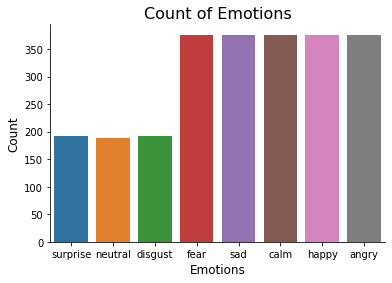

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [8]:
#checking for the data
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

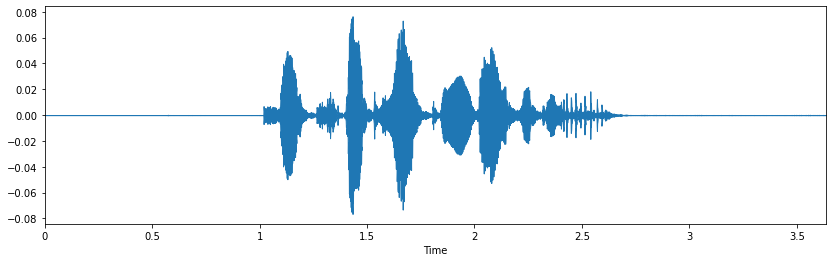

In [9]:
#visualizing a single audio file
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)


In [10]:
#DATA AUGMENTATION

def noise(data):
    noise_amp = 0.025*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.6):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)





In [11]:
 def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally matlab equivalent result = [result zcr]

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    # tonnetz
    tonn = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonn)) #stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result # +1440*3 is our new number of data (number of rows) and columns are 6 features extracted.

In [12]:
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

feature = get_features(path)

feature.shape




/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=862
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=862
  n_fft, y.shape[-1]


(3, 168)

In [13]:
path = np.array(data_path.Path)[1]
path

'/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav'

In [14]:
#checking the shapes of the features
zcr.shape
chroma_stft.shape
mfcc.shape
mfcc.shape
mel.shape

(128,)

In [15]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path) # outputs result matrix (1data*3) * (6)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=862
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=851
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=817
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=828
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=805
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=840
  n_fft, y.shape[-1]


In [16]:
len(X), len(Y), data_path.Path.shape


(7356, 7356, (2452,))

In [17]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,labels
0,0.236364,0.682681,0.670631,0.614893,0.577180,0.557824,0.635630,0.667002,0.664258,0.670328,...,0.000212,0.000081,1.317474e-05,-0.026073,-0.001279,-0.034862,-0.022296,0.012592,0.005958,surprise
1,0.271561,0.688236,0.688241,0.660434,0.640096,0.630405,0.673375,0.678416,0.669367,0.660192,...,0.000225,0.000097,2.797514e-05,-0.023458,0.011311,-0.024778,-0.017178,0.002544,0.003799,surprise
2,0.183618,0.697949,0.671556,0.657487,0.585677,0.503898,0.534870,0.625633,0.642741,0.652293,...,0.000069,0.000017,9.256879e-07,0.012380,0.020663,-0.007584,-0.015508,-0.005813,0.004129,surprise
3,0.249344,0.623057,0.581343,0.598568,0.622959,0.593760,0.598832,0.650681,0.699159,0.683510,...,0.000007,0.000002,2.394534e-07,-0.037990,0.023309,0.017529,-0.038696,0.012354,0.006877,neutral
4,0.298973,0.660275,0.664969,0.715296,0.729957,0.690875,0.648905,0.684672,0.725463,0.706380,...,0.000083,0.000074,7.162529e-05,-0.036027,0.017657,0.026429,-0.034411,0.006483,0.004220,neutral


In [18]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# one hot encoding our y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [32]:
#train test split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 168), (5517, 8), (1839, 168), (1839, 8))

In [33]:
#normalizes the data by -miu/std.dev
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 168), (5517, 8), (1839, 168), (1839, 8))

In [35]:
from numpy import savetxt

savetxt('xtest.csv', x_test, delimiter=',')
savetxt('xtrain.csv', x_train, delimiter = ',')

savetxt('ytest.csv', y_test, delimiter=',')
savetxt('ytrain.csv', y_train, delimiter = ',')

In [36]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 168, 1), (5517, 8), (1839, 168, 1), (1839, 8))

In [37]:
#the convolutional neural network that we are going to use

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 168, 256)          1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 84, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 42, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 42, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 128)          

In [40]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=5, min_lr=0.00000001)
history=model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
22/22 [==============================] - 19s 795ms/step - loss: 2.0251 - accuracy: 0.1834 - val_loss: 1.8912 - val_accuracy: 0.2469
Epoch 2/100
22/22 [==============================] - 17s 792ms/step - loss: 1.8781 - accuracy: 0.2645 - val_loss: 1.7599 - val_accuracy: 0.2860
Epoch 3/100
22/22 [==============================] - 18s 800ms/step - loss: 1.7762 - accuracy: 0.2889 - val_loss: 1.6858 - val_accuracy: 0.3083
Epoch 4/100
22/22 [==============================] - 18s 842ms/step - loss: 1.7056 - accuracy: 0.3201 - val_loss: 1.6054 - val_accuracy: 0.3709
Epoch 5/100
22/22 [==============================] - 17s 757ms/step - loss: 1.6473 - accuracy: 0.3620 - val_loss: 1.5378 - val_accuracy: 0.4182
Epoch 6/100
22/22 [==============================] - 17s 787ms/step - loss: 1.5708 - accuracy: 0.3822 - val_loss: 1.4304 - val_accuracy: 0.4426
Epoch 7/100
22/22 [==============================] - 17s 782ms/step - loss: 1.4980 - accuracy: 0.4243 - val_loss: 1.4300 - val_accuracy:

In [41]:
model.save_weights("312weight.h5")

In [42]:
model.save('./')

In [43]:
x_test.shape

(1839, 168, 1)

In [44]:
y_test.shape

(1839, 8)

In [45]:
print("Accuracy on validation : " , model.evaluate(x_test,y_test)[1]*100 , "%")

58/58 [==============================] - 1s 24ms/step - loss: 0.9744 - accuracy: 0.7879
Accuracy on validation :  78.79282236099243 %


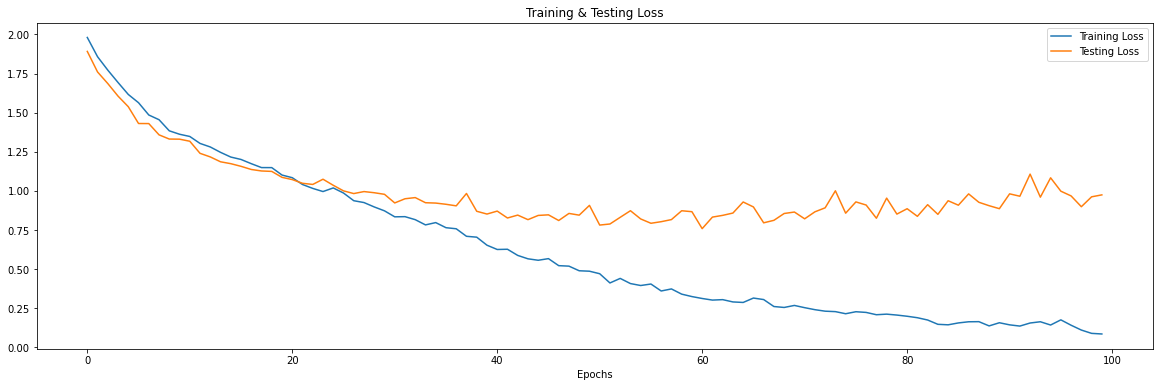

In [51]:
#visual aid of how the metrics vary with accuracy
#plotting the losses

epochs = [i for i in range(100)]
fig , axis = plt.subplots(1,1)


train_loss = history.history['loss']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
axis.plot(epochs , train_loss , label = 'Training Loss')
axis.plot(epochs , test_loss , label = 'Testing Loss')
axis.set_title('Training & Testing Loss')
axis.legend()
axis.set_xlabel("Epochs")

plt.savefig('Losses.png')

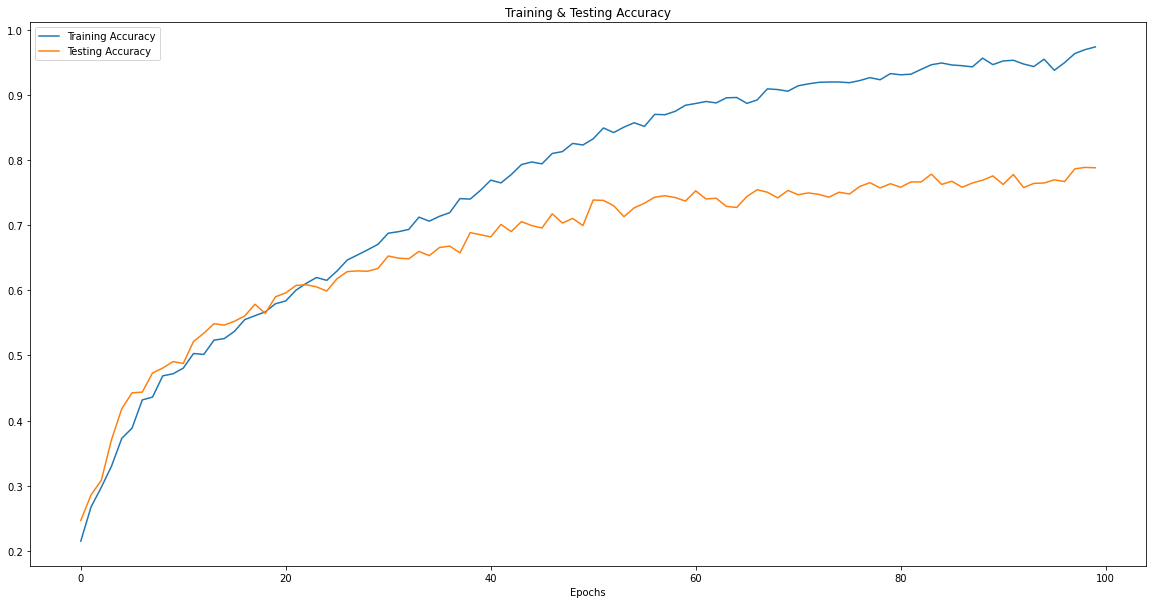

<Figure size 432x288 with 0 Axes>

In [53]:
#plotting the accuracy of the training and the validation set
epochs = [i for i in range(100)]
fig , axis = plt.subplots(1,1)

train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

fig.set_size_inches(20,10)
axis.plot(epochs , train_accuracy , label = 'Training Accuracy')
axis.plot(epochs , test_accuracy , label = 'Testing Accuracy')
axis.set_title('Training & Testing Accuracy')
axis.legend()
axis.set_xlabel("Epochs")
plt.show()

plt.savefig('Accuracy_.png')

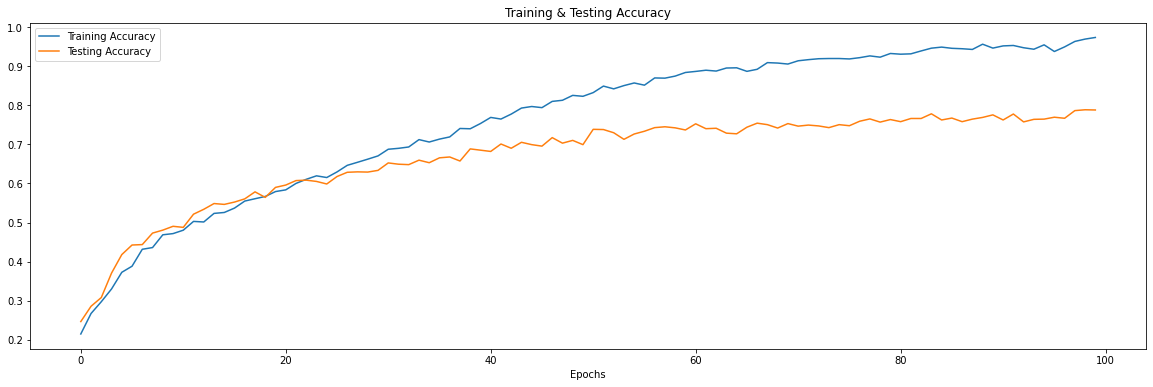

<Figure size 432x288 with 0 Axes>

In [55]:
#plotting the accuracy of the training and the validation set
epochs = [i for i in range(100)]
fig , axis = plt.subplots(1,1)

train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

fig.set_size_inches(20,6)
axis.plot(epochs , train_accuracy , label = 'Training Accuracy')
axis.plot(epochs , test_accuracy , label = 'Testing Accuracy')
axis.set_title('Training & Testing Accuracy')
axis.legend()
axis.set_xlabel("Epochs")
plt.show()

plt.savefig('Accuracies.png')

In [56]:
 # Loads the weights #for pretrained weights see our directory
    
model.load_weights('../input/weightsss/312weight.h5')

# Re-evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

58/58 - 1s - loss: 0.9744 - accuracy: 0.7879
Restored model, accuracy: 78.79%
